# AdaBoost
The following class `AdaBoost` implements the original AdaBoost described by [1] page 2. Each weak leaner is a decision stump somehow similar to the experiments off [2] page 11. The following core features are added

- sparisy:           Take the original trained adaboost and sparisfy down to given # hypothesis. 
- retrain:           Train to X sparsify to y retrain to X. Repeat. 

Besides this a few convinience functions are added. These are all activated through the construction. 

- print_progress:      Print progress of training in load bar and percentages. 
- visualize:           Plot minimal margin, exponential loss and test error.
- (TODO) timing:              Time training, sparsifycation etc. 
- `self.force_silent`  Disable all print statements. 

Finally one can set the field variables 

 
- `self.color` to change the color of a plot if `visualize=True`. 

[1] http://rob.schapire.net/papers/explaining-adaboost.pdf <br>
[2] http://colt2008.cs.helsinki.fi/papers/08-Wang.pdf

In [45]:
%matplotlib notebook
import ipython_notebook_importer
from sklearn.tree import DecisionTreeClassifier
import sparsipy
import numpy as np
import matplotlib.pyplot as plt
import copy

# Change style of plots
plt.style.use('ggplot')

class AdaBoost:

    def __init__(self, visualize=False, print_progress=False, force_silent=False, limit=80, color='-g'):
        ''' Initialize stuff and save settings. '''
        self.visualize       = visualize
        self.print_progress = print_progress

        self.alphas          = []
        self.estimators      = []
        self.color           = color
        self.minimal_margins = []
        self.force_silent    = force_silent
        self.test            = False
        
        self.ylim_mm            = None  
        self.ylim_exploss       = None  
        self.ylim_test_error    = None  
        
        self.limit = limit
        
        
        # Initialize plot if visualization is enabled. 
        if self.visualize: 
            self.fig, (self.ax_margins, self.ax_exp_loss, self.ax_error) = plt.subplots(1, 3, figsize=(10,5))
            self.minimal_margins = []
            self.exp_loss = []
            self.test_error = []
            self.xs = []
              
    
    def fit(self, X, y, T, X_test=None, y_test=None):
        """Fit AddaBoost to (X, y) using T iterations/hypothesis. """
        n, d = X.shape
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
        
        if not X_test is None:
            self.test = True
            self.X_test = X_test
            self.y_test = y_test
            
        # start with uniform distribution and take T steps of AdaBoost
        self.sample_weight = np.ones(n) / n 
        self.step_to(X, y, T)
        
    def step_to(self, X, y, T):
        """Train AdaBoost from it's current # hypothesis to T hypothesis. """
        # Compute remaining number of hypothesis to reach target 'T'
        current_hypothesis = len(self.alphas)
        remaining = T - current_hypothesis
        
        # Boost 'remaining' number of iterations
        for i in range(remaining): 
            # Handles printing & visualizing
            self.inform_user(X, y, i, remaining)
            
            # Take one adaboost step
            done = self.step(X, y) 
            if not done is None: 
                print("BREAK!")
                break
        
        # Handles printing & visualizing of last iteration
        self.inform_user(X, y, i, remaining, last=True)
 

    def step(self, X, y):
        """Learn a single hypothesis and add it to ensemble. """
        # Learn weak guy on weighted data 
        h_t  = DecisionTreeClassifier(max_depth=1) # depth=1 corresponds decision stump. 
        h_t.fit(X, y, sample_weight=self.sample_weight)
        
        assert np.allclose(np.sum(self.sample_weight), 1)
        
        # Compute error of current hypothesis
        eps_t = 1 - h_t.score(X, y, sample_weight=self.sample_weight)

        # Compute weight of current hypothesis given its error
        alpha_t = 1/2 * np.log((1-eps_t)/eps_t)

        # Add weight and weak classifier to list
        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        # Update sample weight to favour points we perform bad on.
        predictions = h_t.predict(X)
        #assert set(predictions)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * predictions )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
    
    
    def inform_user(self, X, y, i, remaining, last=False):
        '''Inform the user by visualizing and printing progress. '''

        # Visualize if enabled
        if self.visualize: self.visualize_step(X, y)
                
        # Print progress
        if self.print_progress: self.do_print_progress(i, remaining, last=last)
                
            
    def do_print_progress(self, i, remaining, last=False):
        """Print progress of training with load bar and in percentages and with time. """
        # we have 60 '=', compute percentages
        percentages = i / remaining
        done_num = int(percentages * 60)
        space_num = 60 - done_num-2
        
        print("\r" + " "*80, end='')
        progress_string = "[" + "="*done_num + ">" + " "*space_num + "]\t" + str(round(percentages*100, 3)) + "%"
        
        print("\r" + progress_string, end='')
                  
        if last:
            print("\r" + " "*120, end='')
            print("\r[" + "="*done_num + ">]\tDONE!\t", flush=True) 
            
          
    def visualize_step(self, X, y):
        """Visualize a step of the algorithm. """
        # Count current number of hypothesis. If first iteration stop. 
        current_hypothesis_count = len(self.alphas)
        if current_hypothesis_count == 0: return
        
        # Add # hypothesis as x value
        self.xs.append(len(self.alphas))

        # TODO: optimize so margins isn't computed twice. 
        self.exp_loss.append(self.exponential_loss(X, y))
        self.minimal_margins.append(self.minimal_margin(X, y))
        if self.test: self.test_error.append(self.error(self.X_test, self.y_test))
        
        # Update plots.
        self.ax_margins.plot(self.xs, self.minimal_margins, self.color)
        self.ax_margins.set_xlabel("# hypothesis")
        self.ax_margins.set_ylabel("Minimal Margin")
        self.ax_margins.set_title("AdaBoost w/ sparsification")
        if not self.ylim_mm is None:
            self.ax_margins.set_ylim(self.ylim_mm)
        
        self.ax_exp_loss.plot(self.xs, self.exp_loss, self.color)
        self.ax_exp_loss.set_xlabel("# hypothesis")
        self.ax_exp_loss.set_ylabel("Exponential Loss")
        self.ax_exp_loss.set_title("AdaBoost Exponential Loss")
        if not self.ylim_exploss is None:
            self.ax_exp_loss.set_ylim(self.ylim_exploss)
        
        
        if self.test: 
            self.ax_error.plot(self.xs, self.test_error, self.color)
        self.ax_error.set_xlabel("# hypothesis")
        self.ax_error.set_ylabel("Test Error")
        self.ax_error.set_title("AdaBoost Test Error")
        if not self.ylim_test_error is None:
            self.ax_error.set_ylim(self.ylim_test_error)
        
        self.fig.canvas.draw()

        
    def predict_unsigned(self, X):
        n, d = X.shape
        pred = [self.alphas[i]*self.estimators[i].predict(X) for i in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        assert pred.shape == (n, ), pred.shape
        return pred
    
    def predict(self, X):
        # np.sign(0)=0, handle this. 
        return np.sign(self.predict_unsigned(X))
    
    # compute the normalized margin!
    # if we don't normalize we can't compare AdaBoost and AdaBoostV
    def normalized_margins(self, X, y):
        pred_unsigned = self.predict_unsigned(X)
        assert sum(np.array(self.alphas) < 0) == 0
        norm_margins = pred_unsigned * y / np.sum(self.alphas)
        return norm_margins
    
    # compute the normalized minimal margin so margin is in [-1, +1]
    # this will not change anything for AdaBoostV
    def minimal_margin(self, X, y):
        return np.min(self.normalized_margins(X, y))

    # compute the exponential loss
    # THIS IS NOT FAIR TO COMPARE WITH ADABOOSTV BECAUSE IT NORMALIZES!
    def exponential_loss(self, X, y):
        n, d = X.shape
        pred_unsigned = self.predict_unsigned(X) #/ np.sum(ada.alphas) 
        margins = pred_unsigned * y
        return np.sum(np.exp(-margins))
    
    def retrain(self, X, y, repeat, max=100, X_test=None, y_test=None):
        '''Train to 100->10, 100->10, ..., ->100'''
        
        if not X_test is None:
            self.test = True
            self.X_test = X_test
            self.y_test = y_test
            self.fit(X, y, max, X_test=X_test, y_test=y_test)
        else:
            self.fit(X, y, max)
            
        ada = self
        
        for i in range(repeat):
            ada = ada.sparsify(X, y, 10, color=(i+1)/repeat)
            
        return ada
    
    
    def sparsify(self, X, y, target, select="mm", color=3/10):
        '''
        Given data X and labels y, uses discrepancy minimization to
        sparsify the hypothesis gained. How do we select the best one?
        
        color should be a fraction, it is then translatd to that fraction of hex space.
        '''
        hexmax = (2**8)**3
        self.color = str(hex(int(hexmax*color/2))).replace("0x", "#")
        self.color.replace(self.color[5:], "ff")        
        
        U = self.compute_matrix(X, y) # this is correct. 
        n, T = U.shape
        print(U)
        
        # multiply rows before sparisfication
        
        unnormalized_predictions = [self.alphas[t]*self.estimators[t].predict(X) 
                            for t in range(len(self.estimators))]
        unnormalized_predictions = np.sum(unnormalized_predictions, axis=0)
        unnormalized_margins = y * unnormalized_predictions
        exp = np.exp(-unnormalized_margins)
        exp = exp / np.sum(exp)
        exp = exp.reshape(n, 1)
        print(exp.shape)
        exp = exp.repeat(T, axis=1) # normalize?
        print(exp.shape)
        U = exp * U
        
        print(U)
        
        w = self.alphas
        w = sparsipy.sparsify(U, w, target) # this is correct
        
        best_exploss = float("inf")
        best_mm = -2.0
        best_ada = None
        
        
        for i in range(len(w)-1, 0, -1):
            current_ada = copy.deepcopy(self)
            non_zero = sum(w[i] != 0)
            if non_zero > self.limit: break
            
            # find the non-zero entries of w in alpha/estimators. 
            lists = []
            for j in range(w.shape[1]):
                lists.append( (w[i][j], current_ada.estimators[j]) )
            #lists = sorted(lists, key = lambda x: x[0], reverse=True)
            
            # add estimators/alphas with positive weight/alpha
            current_ada.estimators = [tupple[1] for tupple in lists if tupple[0] > 0.0] 
            current_ada.alphas     = [tupple[0] for tupple in lists if tupple[0] > 0.0]

   
            # update sample weight ;; maybe these shouldn't be normalized?
            unnormalized_predictions = [current_ada.alphas[t]*current_ada.estimators[t].predict(X) 
                                        for t in range(len(current_ada.estimators))]
            unnormalized_predictions = np.sum(unnormalized_predictions, axis=0)
            unnormalized_margins = y * unnormalized_predictions
            
            current_ada.sample_weight = np.exp(- unnormalized_margins) 
            current_ada.sample_weight = current_ada.sample_weight / np.sum(current_ada.sample_weight)
            
            # Compute current minimal margin
            current_minmal_margin = current_ada.minimal_margin(X, y)
            
            if not self.force_silent: print("")
            
            # visualize=True => compute all margins so we can print AdaBoost directs compared to ours. 
            if self.visualize: 
                if not self.force_silent: 
                    print("Sparsify %i gave margin: \t"%(non_zero), current_minmal_margin, "\t(%f)"%self.minimal_margins[non_zero])
            else: 
                if not self.force_silent: print("Sparsify %i gave margin: \t"%(non_zero), current_minmal_margin)
            
            current_ada.step_to(X, y, T)
            
            # Compute current minimal margin after retraining
            current_minmal_margin = current_ada.minimal_margin(X, y)
            
            if not self.force_silent: print("Train %i -> %i gave margin: \t"%(non_zero, T), current_minmal_margin)  
            
            # Select the best by minimal margin or exponential loss.
            if select == "mm":
                mm = current_ada.minimal_margin(X, y)
                if mm > best_mm:
                    best_mm = mm
                    best_ada = current_ada
            elif select == "exploss":
                exploss = self.exponential_loss(X, y)
                if exploss < best_exploss:
                    best_exploss = exploss
                    best_ada = current_ada
                
        # Return the best ada found so far.
        return best_ada
            
        
    def compute_matrix(self, X, y): 
        '''
        Compute matrix U such that U_ij = h_j(x_i)
        Notice U will have size n x T
        '''
        T = len(self.alphas)
        n, d = X.shape
        U = np.zeros( (n, T) )
        
        for i in range(T):
            U[:, i] = self.estimators[i].predict(X)
            
        return U
    
    def score(self, X, y):
        n, d = X.shape
        pred = self.predict(X)
        return sum(pred == y) / n
    
    def error(self, X, y):
        return 1-self.score(X, y)
    
    def __deepcopy__(self, memo):
        shallow_copy = copy.copy(self)
        shallow_copy.alphas = copy.deepcopy(self.alphas)
        shallow_copy.estimators = copy.deepcopy(self.estimators)
        
        # override xs and minimal_margins
        shallow_copy.xs = []
        shallow_copy.minimal_margins = []
        shallow_copy.exp_loss = []
        shallow_copy.test_error = []
        
        return shallow_copy
    



In [ ]:
# todo. 

# Experiment: Sparsify (T=64)

Direct mm 1000: 	 -0.026993828994
Direct E_test 1000: 	 0.096


<IPython.core.display.Javascript object>


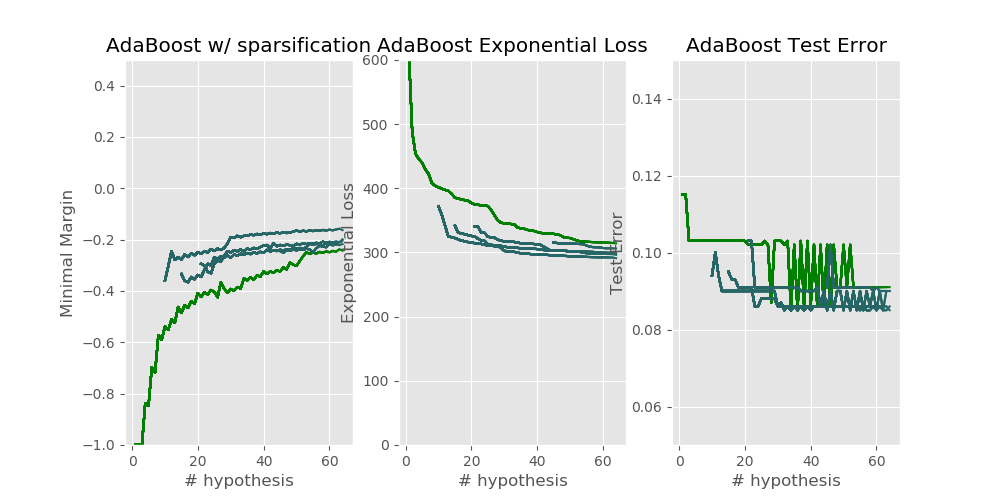

[[-1. -1.  1. ...,  1. -1.  1.]
 [ 1.  1.  1. ...,  1. -1.  1.]
 [ 1. -1.  1. ...,  1. -1.  1.]
 ..., 
 [-1. -1. -1. ...,  1. -1. -1.]
 [ 1. -1.  1. ...,  1. -1.  1.]
 [-1. -1.  1. ...,  1. -1.  1.]]
(1000, 1)
(1000, 64)
[[ -2.61619657e-04  -2.61619657e-04   2.61619657e-04 ...,   2.61619657e-04
   -2.61619657e-04   2.61619657e-04]
 [  3.71919730e-04   3.71919730e-04   3.71919730e-04 ...,   3.71919730e-04
   -3.71919730e-04   3.71919730e-04]
 [  1.47172030e-03  -1.47172030e-03   1.47172030e-03 ...,   1.47172030e-03
   -1.47172030e-03   1.47172030e-03]
 ..., 
 [ -5.95306771e-05  -5.95306771e-05  -5.95306771e-05 ...,   5.95306771e-05
   -5.95306771e-05  -5.95306771e-05]
 [  1.47172030e-03  -1.47172030e-03   1.47172030e-03 ...,   1.47172030e-03
   -1.47172030e-03   1.47172030e-03]
 [ -5.69289557e-03  -5.69289557e-03   5.69289557e-03 ...,   5.69289557e-03
   -5.69289557e-03   5.69289557e-03]]


In [46]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

# Get DataSet
data = ds.DataSet("generate2", split=True)

# BaseLine
ada = AdaBoost(visualize=False, print_progress=False)
ada.fit(data.X, data.y, 1000)
print("Direct mm 1000: \t", ada.minimal_margin(data.X, data.y))
print("Direct E_test 1000: \t", ada.error(data.X_test, data.y_test))


T = 64

ada = AdaBoost(visualize=True, force_silent=True)

ada.ylim_mm = [-1.0, 0.5]
ada.ylim_exploss = [0, 600]
ada.ylim_test_error = [0.05, 0.15]

ada.fit(data.X, data.y, T, X_test=data.X_test, y_test=data.y_test)
ada.sparsify(data.X, data.y, 10)

# Experiment: Retrain (T=64)

Direct mm 1000: 	 -0.00669982549962
Direct E_test 1000: 	 0.114


<IPython.core.display.Javascript object>


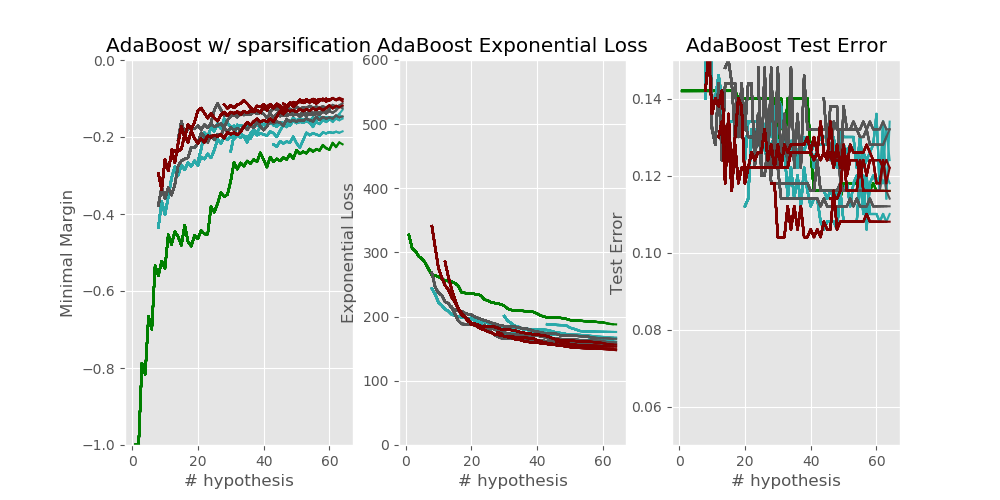

[[ 1.  1.  1. ..., -1.  1. -1.]
 [ 1. -1.  1. ..., -1.  1. -1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1. -1.  1. ..., -1.  1. -1.]
 [-1. -1.  1. ..., -1.  1. -1.]
 [ 1. -1.  1. ..., -1.  1. -1.]]
(500, 1)
(500, 64)
[[  1.65318178e-04   1.65318178e-04   1.65318178e-04 ...,  -1.65318178e-04
    1.65318178e-04  -1.65318178e-04]
 [  4.49418517e-03  -4.49418517e-03   4.49418517e-03 ...,  -4.49418517e-03
    4.49418517e-03  -4.49418517e-03]
 [  1.38388161e-05   1.38388161e-05   1.38388161e-05 ...,   1.38388161e-05
    1.38388161e-05   1.38388161e-05]
 ..., 
 [  2.21920544e-03  -2.21920544e-03   2.21920544e-03 ...,  -2.21920544e-03
    2.21920544e-03  -2.21920544e-03]
 [ -1.52551322e-03  -1.52551322e-03   1.52551322e-03 ...,  -1.52551322e-03
    1.52551322e-03  -1.52551322e-03]
 [  2.21920544e-03  -2.21920544e-03   2.21920544e-03 ...,  -2.21920544e-03
    2.21920544e-03  -2.21920544e-03]]
[[ 1.  1. -1. ..., -1.  1. -1.]
 [ 1. -1. -1. ..., -1.  1. -1.]
 [ 1.  1.  1. ..., -1.  1. -1.]
 ...,

In [47]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

# Get DataSet
data = ds.DataSet("generate1", split=True)

# Baseline
ada = AdaBoost(visualize=False, force_silent=True)
ada.fit(data.X, data.y, 1000)
print("Direct mm 1000: \t", ada.minimal_margin(data.X, data.y))
print("Direct E_test 1000: \t", ada.error(data.X_test, data.y_test))

# Retrain 64
T = 64

ada = AdaBoost(visualize=True, force_silent=True)

ada.ylim_mm = [-1.0, 0]
ada.ylim_exploss = [0, 600]
ada.ylim_test_error = [0.05, 0.15]

ada.retrain(data.X, data.y, repeat=3, max=T, X_test =data.X_test, y_test=data.y_test)

# Experiment: Sparisfy (all datasets, T=128)

<IPython.core.display.Javascript object>


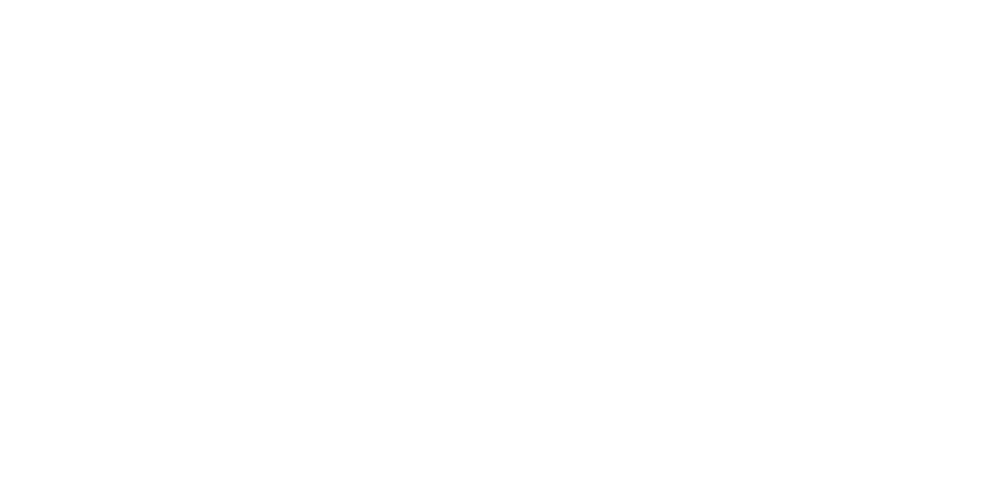

TypeError: unhashable type: 'numpy.ndarray'

In [7]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

T = 128

for name in ds.DataSet.names:

    data = ds.DataSet(name, split=True)

    ada = AdaBoost(visualize=True, force_silent=True)
    ada.fig.suptitle("DataSet: " + name)
    ada.fit(data.X, data.y, T, X_test=data.X_test, y_test=data.y_test)
    ada.sparsify(data.X, data.y, 10)

# Experiment: Retrain (all datasets, T=64)

Direct mm 500: 		 -0.0539412661509
Direct E_test 500: 	 0.09


<IPython.core.display.Javascript object>


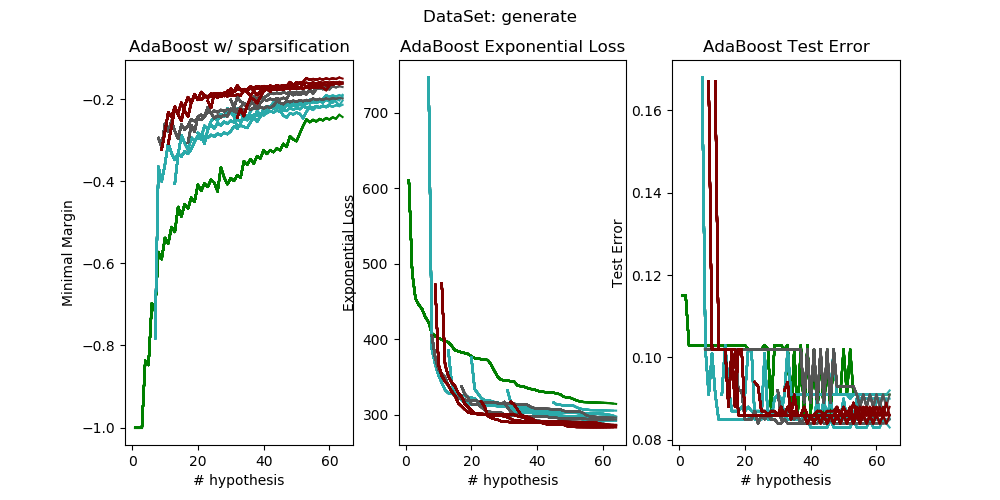

Direct mm 500: 		 -0.0539412661509
Direct E_test 500: 	 0.09


<IPython.core.display.Javascript object>


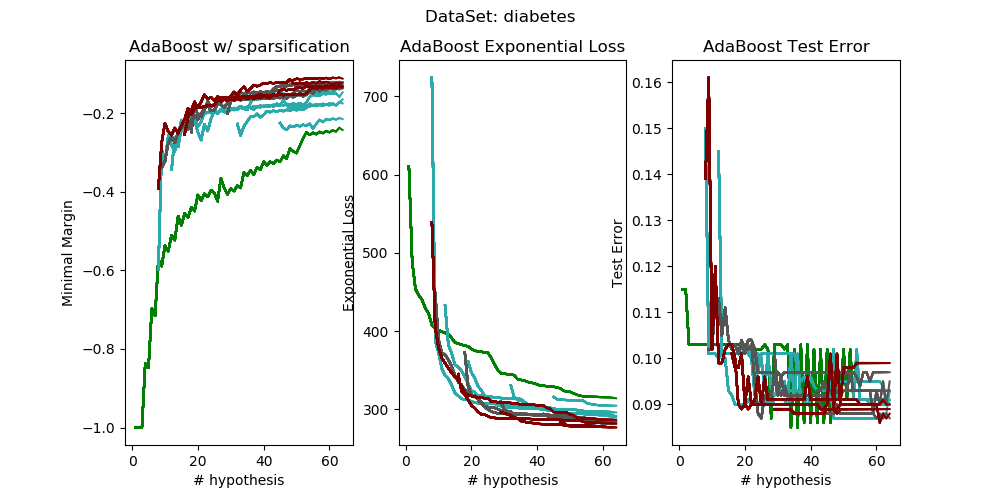

Direct mm 500: 		 -0.0539412661509
Direct E_test 500: 	 0.09


<IPython.core.display.Javascript object>


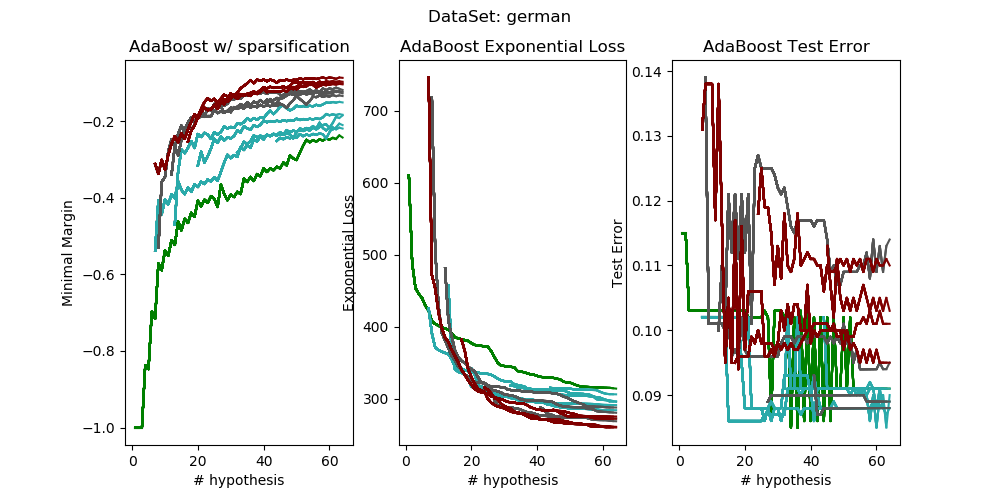

Direct mm 500: 		 -0.0539412661509
Direct E_test 500: 	 0.09


<IPython.core.display.Javascript object>


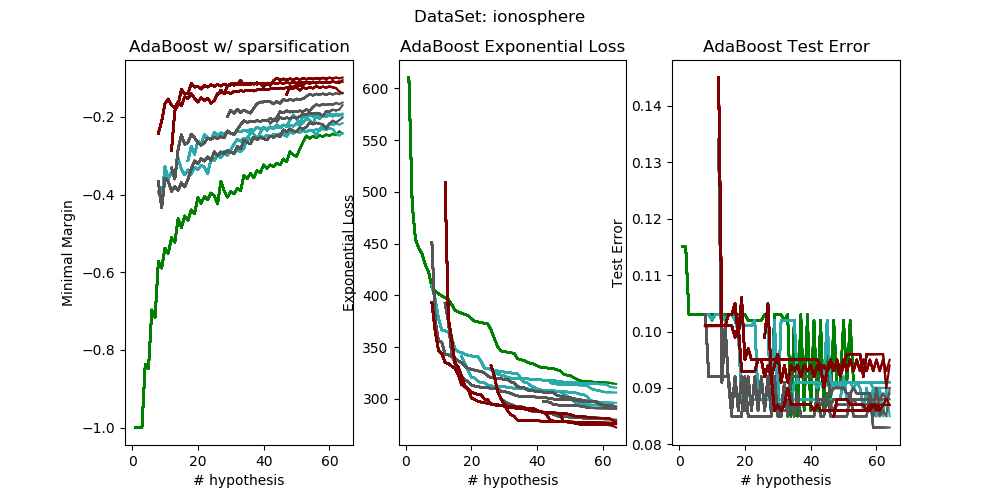

Direct mm 500: 		 -0.0539412661509
Direct E_test 500: 	 0.09


<IPython.core.display.Javascript object>


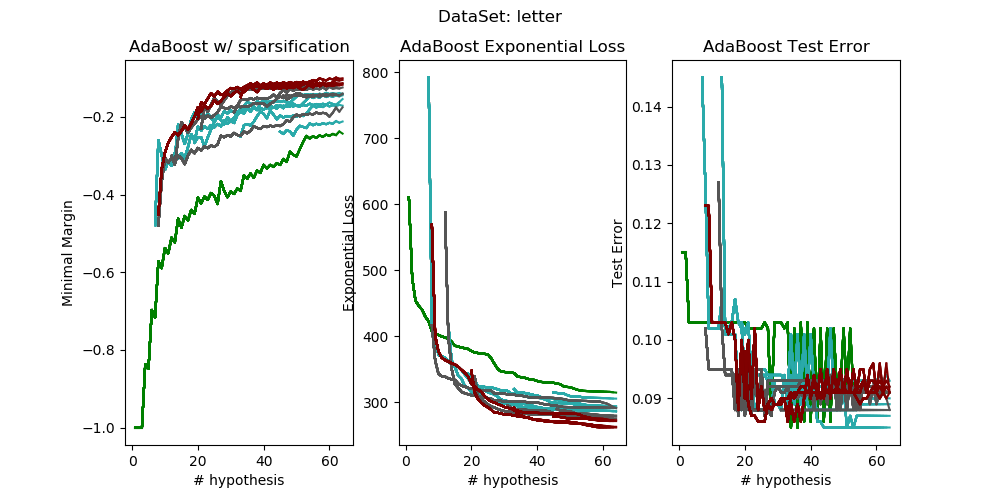

In [7]:
%matplotlib notebook
import ipython_notebook_importer
import DataSet as ds

T = 64
for name in ds.DataSet.names:

    data = ds.DataSet(name, split=True)
    
    ada = AdaBoost(visualize=False, force_silent=True)
    ada.fit(data.X, data.y, 500)
    print("Direct mm 500: \t\t", ada.minimal_margin(data.X, data.y))
    print("Direct E_test 500: \t", ada.error(data.X_test, data.y_test))

    ada = AdaBoost(visualize=True, force_silent=True)
    ada.fig.suptitle("DataSet: " + name)
    ada.retrain(data.X, data.y, repeat=3, max=T, X_test =data.X_test, y_test=data.y_test)
